### Import Libraries
Import the relevant libraries used for the analysis

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_selection import f_regression

### Read the Airbnb data

The Airbnb data set for Toronto was obtained from http://insideairbnb.com/get-the-data.html

In [2]:
data = pd.read_csv("listings.csv")
display(data.head())
display(data.shape)

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name  neighbourhood_group                      neighbourhood  \
0       Alexandra                  NaN                    Little Portugal   
1  Kathie & Larry                  NaN  Waterfront Communities-The Island   
2            Rona                  NaN                              Annex   
3   Yohan & Sarah                  NaN               Briar Hill-Belgravia   
4           Brent                  NaN                  Greenwood-Coxwell   

   latitude  longitude        room_type  price  minimum_nights  \
0  43.64617  -79.42451  Entire home/apt    469               4   
1  43.64105  -79.37628     Private room     96             180   
2  43.66724  -79.41598     Private room     64               1   
3  43.69602  -79.45468     Private room     70               1   
4  43.66890  -79.32592  Entire home/apt     45             365   

   number_of_reviews last_review  reviews_per_month  \
0                  7  2017-12-04               0.11   
1                169  2013-08-27               1.22   
2                  0         NaN                NaN   
3                217  2019-12-22               1.68   
4                 26  2011-08-30               0.20   

   calculated_host_listings_count  availability_365  
0                               1                 0  
1                               2               365  
2                               1                 0  
3                               2               324  
4                               1                 0

(18265, 16)

### Exploratory data analysis
Let's check for the missing values in the above data set and perform some preliminary exploratory analysis

In [3]:
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
id                                           0    0.000000
name                                         1    0.005475
host_id                                      0    0.000000
host_name                                   11    0.060224
neighbourhood_group                      18265  100.000000
neighbourhood                                0    0.000000
latitude                                     0    0.000000
longitude                                    0    0.000000
room_type                                    0    0.000000
price                                        0    0.000000
minimum_nights                               0    0.000000
number_of_reviews                            0    0.000000
last_review                               4105   22.474678
reviews_per_month                         4105   22.474678
calculated_host_listings_count               0    0.000000
availability_365                             0    0.000000

As seen in the table above, the column "neighbourhood_group" is an empty column and hence can be deleted. Additionaly, we have one missing value in the "name" column, 11 in "host_name", 4105 in "last_review" and "reviews_per_month". Let's also delete the "last_review" and "reviews_per_month" column due to over 22 percent of missing values. Upon further investigation, "minimum_nights" and "availability_365" were found to be inconsistent. Let's delete those columns too.  

In [4]:
data.drop(['neighbourhood_group','last_review','reviews_per_month','minimum_nights','availability_365'],axis=1,inplace=True)
display(data.head())

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name                      neighbourhood  latitude  longitude  \
0       Alexandra                    Little Portugal  43.64617  -79.42451   
1  Kathie & Larry  Waterfront Communities-The Island  43.64105  -79.37628   
2            Rona                              Annex  43.66724  -79.41598   
3   Yohan & Sarah               Briar Hill-Belgravia  43.69602  -79.45468   
4           Brent                  Greenwood-Coxwell  43.66890  -79.32592   

         room_type  price  number_of_reviews  calculated_host_listings_count  
0  Entire home/apt    469                  7                               1  
1     Private room     96                169                               2  
2     Private room     64                  0                               1  
3     Private room     70                217                               2  
4  Entire home/apt     45                 26                               1

## Calculate the distance traveled

We cannot incoporate the latitude and longitude directly. But, we can include new columns that calculates the distance between a few landmarks to the location of each of the AirBnBs (I have chosen CN Tower, The harbourfront and Nathan Philips Square.

The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br> Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

In [5]:
def haversine_distance(data,lat2, long2,lat1='latitude',long1='longitude'):
    
    r = 6371
       
    phi1 = np.radians(data[lat1])
    phi2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2-data[lat1])
    delta_lambda = np.radians(long2-data[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
lat2,long2 = [43.64271, 43.63942, 43.65329],[-79.38707, -79.38294, -79.38366]

for i in range(0,len(lat2)):
    data['distance'+str(i+1)+'_km'] = haversine_distance(data,lat2[i],long2[i])

display(data.head())

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  12604               Seaton Village Parlour Bedroom    48239   
3  23691              Queen Bedroom close to downtown    93825   
4  27423  Executive Studio Unit- Ideal for One Person   118124   

        host_name                      neighbourhood  latitude  longitude  \
0       Alexandra                    Little Portugal  43.64617  -79.42451   
1  Kathie & Larry  Waterfront Communities-The Island  43.64105  -79.37628   
2            Rona                              Annex  43.66724  -79.41598   
3   Yohan & Sarah               Briar Hill-Belgravia  43.69602  -79.45468   
4           Brent                  Greenwood-Coxwell  43.66890  -79.32592   

         room_type  price  number_of_reviews  calculated_host_listings_count  \
0  Entire home/apt    469                  7                               1   
1     Private room     96                169                               2   
2     Private room     64                  0                               1   
3     Private room     70                217                               2   
4  Entire home/apt     45                 26                               1   

   distance1_km  distance2_km  distance3_km  
0      3.037067      3.428184      3.380705  
1      0.887655      0.565751      1.484922  
2      3.584597      4.078628      3.027505  
3      8.044269      8.538512      7.429621  
4      5.716838      5.638200      4.958477

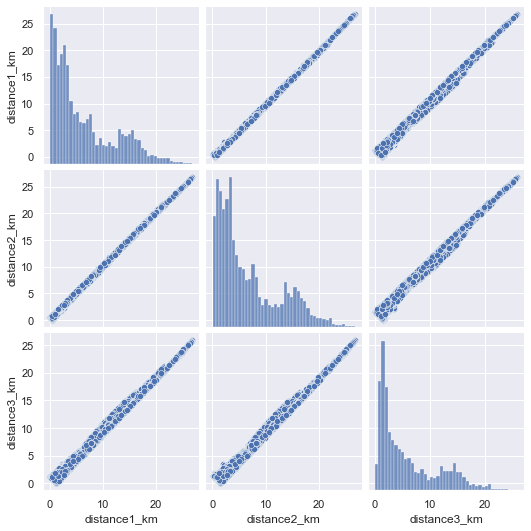

In [7]:
sns.set(font_scale=1,rc={'figure.figsize':(18,12)});
sns.pairplot(data[['distance1_km','distance2_km','distance3_km']]);

It looks like all the three distances are highly correlated. Therefore, we could just work with one of the distances. Adding all the three results in collinearity of the independent variables.

In [8]:
data.drop(['distance2_km','distance3_km'],axis=1,inplace=True)

In [9]:
price_stat = pd.DataFrame(data['price'].describe())
display(price_stat)

price
count  18265.000000
mean     137.659677
std      306.423241
min        0.000000
25%       60.000000
50%       95.000000
75%      149.000000
max    13000.000000

From the above table, we can observe the minimum value for the price to be zero. We can take a look at these entries and decide to look up the actual price or just delete the entry.

In [10]:
display(data[data['price']==0])

id                                              name    host_id  \
15413  42738772           Residence & Conference Centre - Toronto  332023628   
15793  43309343  Residence & Conference Centre - Toronto Downtown  316829844   

                           host_name                      neighbourhood  \
15413                            Rcc                  Hillcrest Village   
15793  Residence & Conference Centre  Waterfront Communities-The Island   

       latitude  longitude   room_type  price  number_of_reviews  \
15413  43.79633  -79.34674  Hotel room      0                  0   
15793  43.65444  -79.35632  Hotel room      0                  0   

       calculated_host_listings_count  distance1_km  
15413                               1     17.386526  
15793                               1      2.796876

A simple google search showed me that it costs about 75 dollars per night at RCC. We set the price for the above two listings to be 75.

In [11]:
data.loc[data['price']==0,'price'] = 75

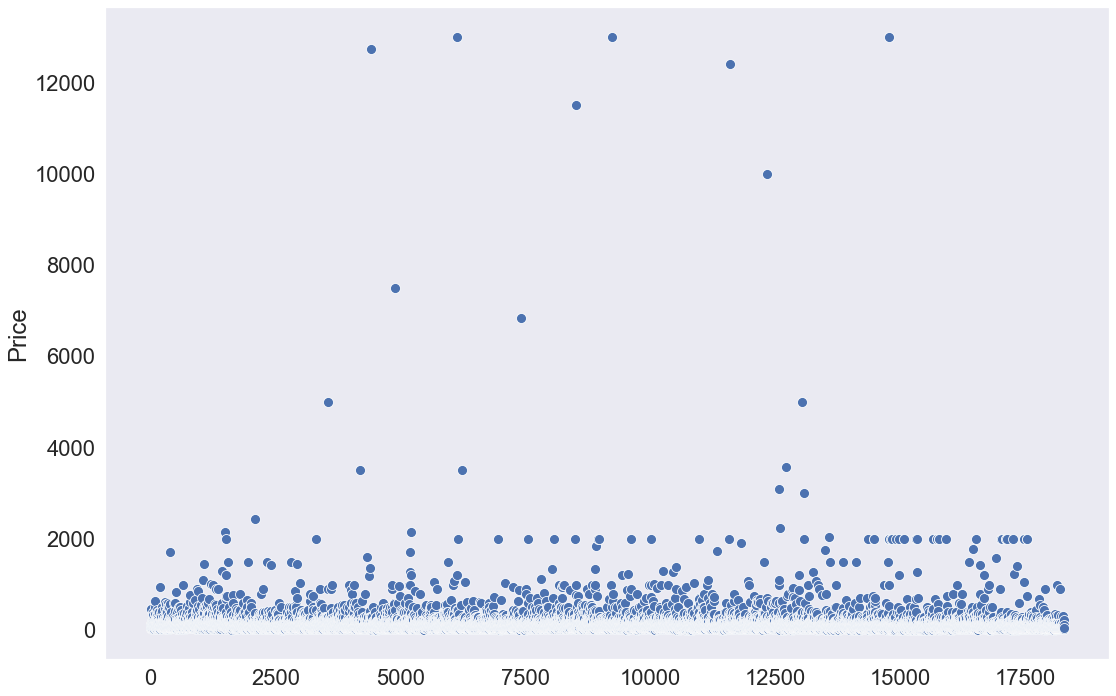

In [12]:
sns.set(font_scale=2,rc={'figure.figsize':(18,12)})
ax = sns.scatterplot(x=data.index,y=data['price'],s=100);
ax.set(ylabel='Price')
ax.grid(False);

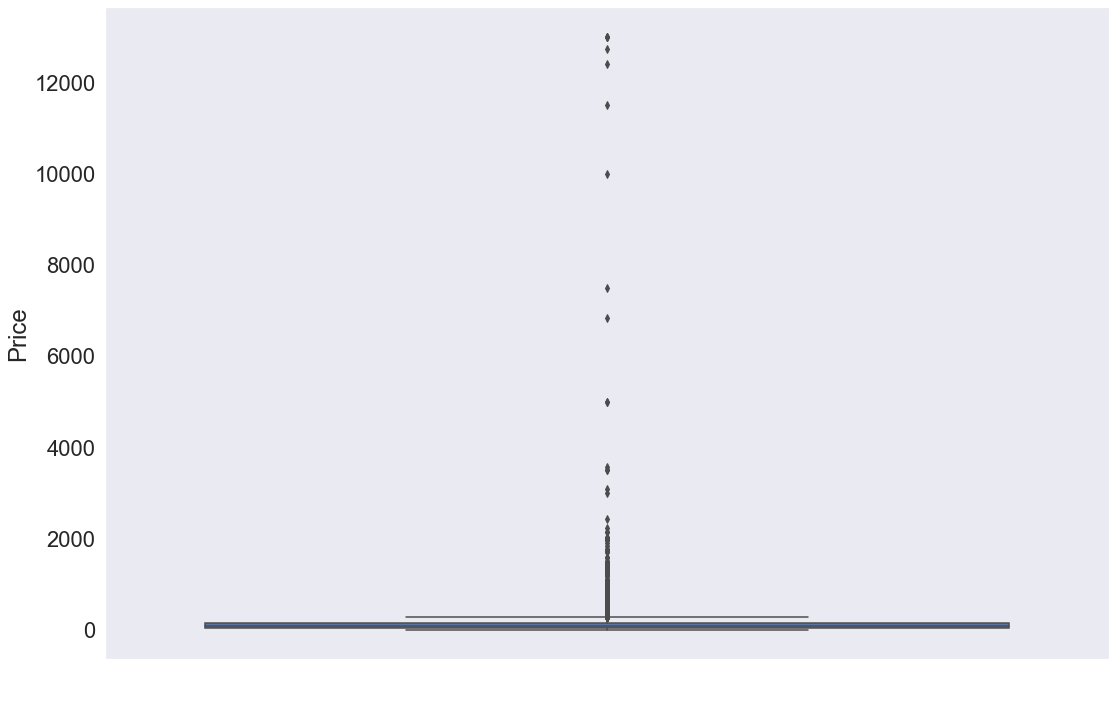

In [13]:
ax = sns.boxplot(y='price',  data=data)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

The scatter plot and box plot reveal a lot of outliers to be present. In our case outliers are high priced rooms. Upon further investigation, I found some of the rooms to be highly priced, while some other rooms have reported prices for multiple nights and hence standing out. Some of the listings have a component of "art" attached to them, making it pricey.
We can take a quick look at the location of these luxury listings and remove them from our data set.

In [14]:
upper_lim_price = float(price_stat.iloc[6] + 1.5*(price_stat.iloc[6] - price_stat.iloc[4]))
outlier_data = data[data['price']>upper_lim_price]
display(outlier_data.head())
display(outlier_data.shape)

id                                               name  host_id  \
0     1419                    Beautiful home in amazing area!     1565   
53  228568                BEST VIEW in the City! Luxury condo   934821   
54  229913                 Upscale 2bed Downtown Toronto-lake  1200620   
79  361599  Luxury House in Downtown For 12people+  6 parking   174063   
82  366973                Spacious Modern Cozy King W Toronto  1015670   

    host_name                      neighbourhood  latitude  longitude  \
0   Alexandra                    Little Portugal  43.64617  -79.42451   
53        Rob                North St.James Town  43.66771  -79.37679   
54     Sergei                            Niagara  43.63479  -79.39957   
79      Denis                     South Parkdale  43.63737  -79.43939   
82      Grace  Waterfront Communities-The Island  43.64341  -79.40046   

          room_type  price  number_of_reviews  calculated_host_listings_count  \
0   Entire home/apt    469                  7                               1   
53  Entire home/apt    400                 56                               2   
54  Entire home/apt    325                 10                               1   
79  Entire home/apt    500                  0                               5   
82  Entire home/apt    361                  9                               1   

    distance1_km  
0       3.037067  
53      2.900288  
54      1.336941  
79      4.251888  
82      1.080255

(1200, 12)

### Read the geoJSON neighbourhood data

In [15]:
count = data.groupby(['neighbourhood']).size().reset_index(name='count')
display(count.head())

neighbourhood  count
0               Agincourt North     38
1  Agincourt South-Malvern West    104
2                     Alderwood     23
3                         Annex    586
4             Banbury-Don Mills     54

In [16]:
neigh_data = gpd.read_file('neighbourhoods.geojson')
neigh_data.drop(['neighbourhood_group'],axis=1,inplace=True)
display(neigh_data.head())

geo_data = neigh_data.merge(count,on='neighbourhood')
display(geo_data.head())

neighbourhood                                           geometry
0  York University Heights  MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...
1              The Beaches  MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...
2      Scarborough Village  MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...
3           South Parkdale  MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...
4          South Riverdale  MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...

neighbourhood                                           geometry  \
0  York University Heights  MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...   
1              The Beaches  MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...   
2      Scarborough Village  MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...   
3           South Parkdale  MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...   
4          South Riverdale  MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...   

   count  
0    175  
1    151  
2     18  
3    299  
4    340

In [17]:
map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=11)

folium.Choropleth(geo_data = neigh_data,
                  data = count,
                  columns = ['neighbourhood','count'],
                  key_on = 'feature.properties.neighbourhood',
                  fill_color='BuPu',
                  fill_opacity=0.8, 
                  line_opacity=1,
                  legend_name='Covid cases by FSA').add_to(map_toronto)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 1}

interac_feat = folium.features.GeoJson(data = geo_data,
                                       style_function = style_function,
                                       control = False,
                                       tooltip = folium.features.GeoJsonTooltip(
                                       fields = ['neighbourhood','count'],
                                       aliases = ['Neighbourhood name: ', 'Number of listings: '],
                style=("background-color: white; color: #000000; font-family: arial; font-size: 15px; padding: 10px;")
                                       )
                                      )
               
    
map_toronto.add_child(interac_feat)
map_toronto.keep_in_front(interac_feat)
folium.LayerControl().add_to(map_toronto)


map_toronto

In [18]:
coord_list = outlier_data[['latitude','longitude']].values.tolist()

for coord in range(0, len(coord_list)):
    folium.Marker(coord_list[coord], popup=data['name'][coord]).add_to(map_toronto)

map_toronto

#### Remove the outlier data for further analysis

In [19]:
data.drop(['latitude','longitude','name','host_id','host_name'],axis=1,inplace=True)
data.drop(data[data['price']>upper_lim_price].index,inplace=True)
display(data.head())
display(data.shape)

id                      neighbourhood        room_type  price  \
1   8077  Waterfront Communities-The Island     Private room     96   
2  12604                              Annex     Private room     64   
3  23691               Briar Hill-Belgravia     Private room     70   
4  27423                  Greenwood-Coxwell  Entire home/apt     45   
5  30931  Waterfront Communities-The Island  Entire home/apt    127   

   number_of_reviews  calculated_host_listings_count  distance1_km  
1                169                               2      0.887655  
2                  0                               1      3.584597  
3                217                               2      8.044269  
4                 26                               1      5.716838  
5                  1                               2      0.866513

(17065, 7)

#### Stripplot for Room type vs Price

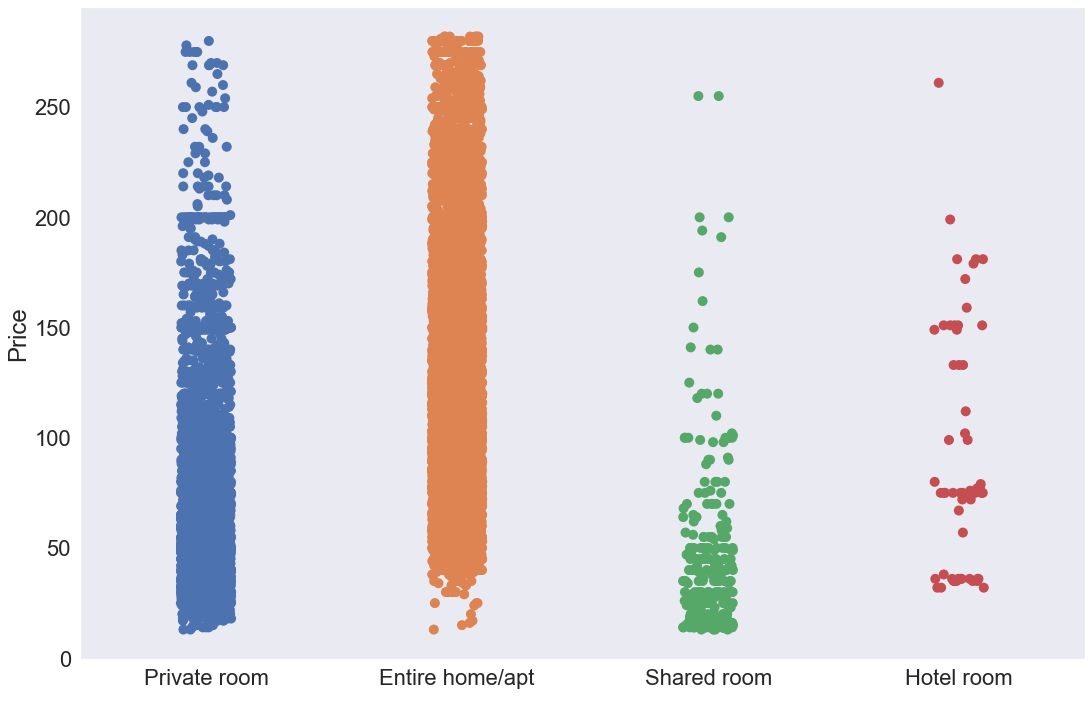

In [20]:
ax = sns.stripplot(x='room_type', y='price',data=data,s=10)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

#### Box plot for Room type vs Price

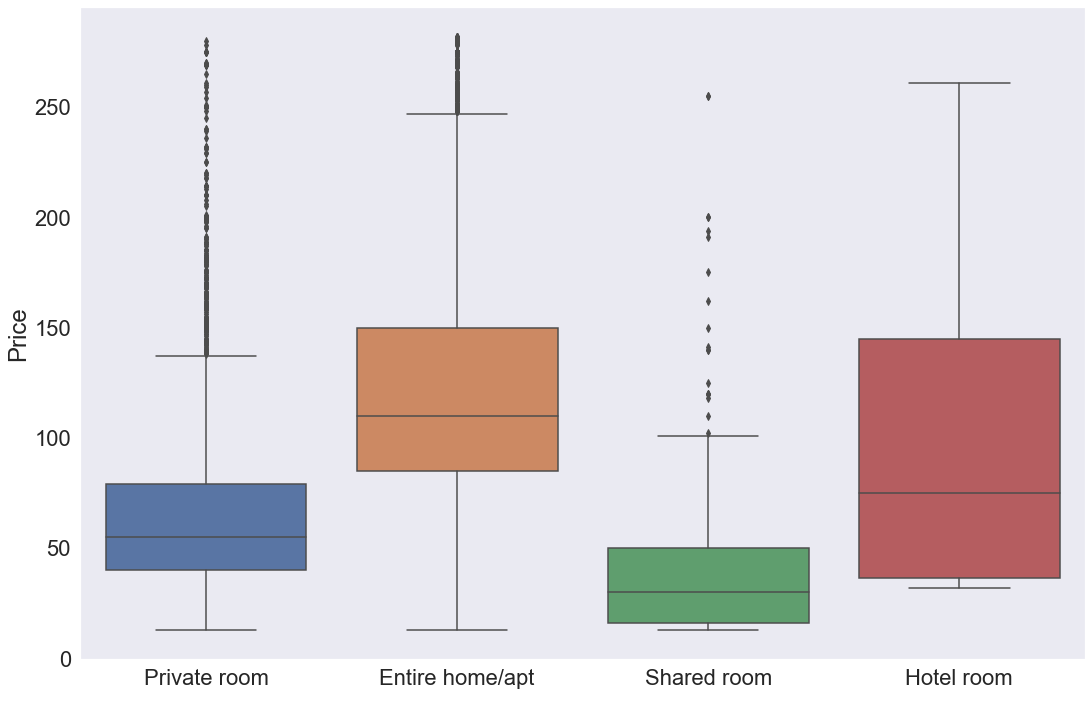

In [21]:
ax = sns.boxplot(x='room_type', y='price',  data=data)
ax.set(xlabel = ' ',ylabel='Price')
ax.grid(False);

#### Summary statistics for various room types

In [22]:
room_data = pd.DataFrame({'Entire Home/Apt':data.loc[data['room_type']=='Entire home/apt','price'].describe(), 
                      'Private Room':data.loc[data['room_type']=='Private room','price'].describe(),
                     'Shared Room':data.loc[data['room_type']=='Shared room','price'].describe(),
                     'Hotel Room':data.loc[data['room_type']=='Hotel room','price'].describe()})

display(room_data)

Entire Home/Apt  Private Room  Shared Room  Hotel Room
count     10455.000000   6250.000000   302.000000   58.000000
mean        123.492970     65.266400    42.745033   93.482759
std          52.055813     37.488078    39.011173   54.654655
min          13.000000     13.000000    13.000000   32.000000
25%          85.000000     40.000000    16.000000   36.500000
50%         110.000000     55.000000    30.000000   75.000000
75%         150.000000     79.000000    50.000000  145.000000
max         282.000000    280.000000   255.000000  261.000000

In [23]:
room_data_1 = pd.DataFrame({'Percentage':room_data.iloc[0]*100/data.shape[0]})

display(room_data_1)

Percentage
Entire Home/Apt   61.265749
Private Room      36.624670
Shared Room        1.769704
Hotel Room         0.339877

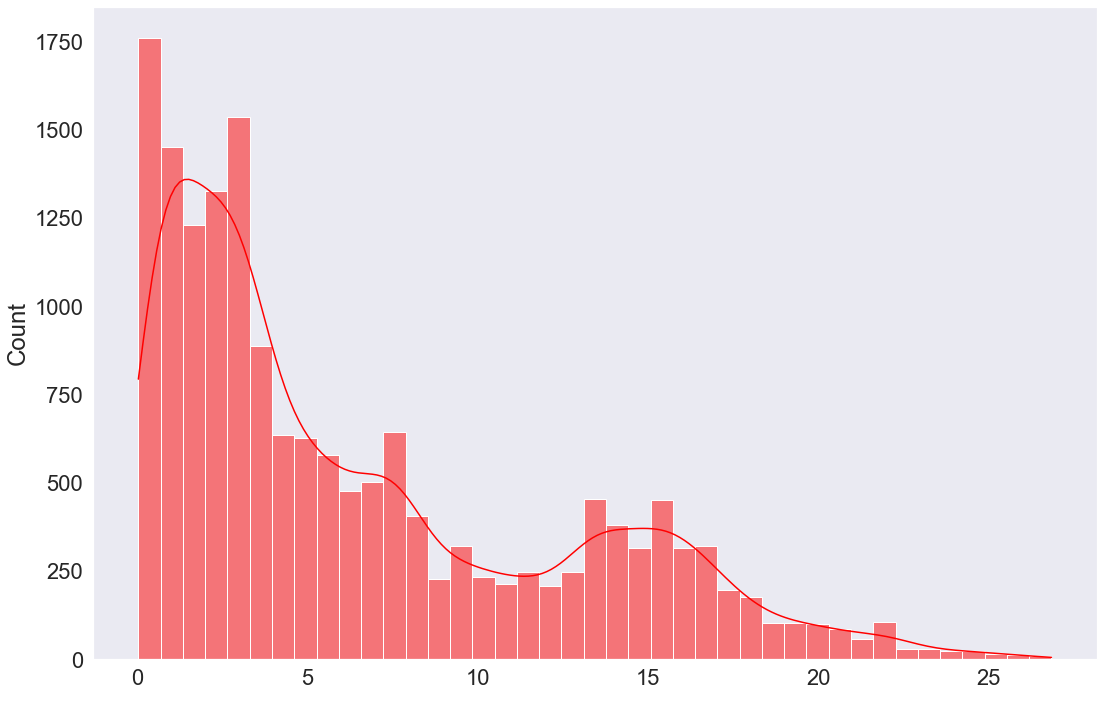

In [24]:
ax = sns.histplot( data['distance1_km'], color="red", kde=True)
ax.set(ylabel='Count',xlabel=' ')
ax.grid(False);

### One hot encoding of categorical features

In [25]:
encoder1 = OneHotEncoder(sparse=False)

room_type_encode = pd.DataFrame(encoder1.fit_transform(data[['room_type']]))
room_type_encode.columns = [word.replace('room_type_','') for word in list(encoder1.get_feature_names(['room_type']))]

encoder2 = OneHotEncoder(sparse=False)

neighbourhood_encode = pd.DataFrame(encoder2.fit_transform(data[['neighbourhood']]))
neighbourhood_encode.columns = [word.replace('room_type_','') for word in list(encoder2.get_feature_names(['neighbourhood']))]

data = pd.concat([data.reset_index(), room_type_encode, neighbourhood_encode],axis=1)

data.drop(['index','room_type','neighbourhood','id'],axis=1,inplace=True)

display(data.head())

price  number_of_reviews  calculated_host_listings_count  distance1_km  \
0     96                169                               2      0.887655   
1     64                  0                               1      3.584597   
2     70                217                               2      8.044269   
3     45                 26                               1      5.716838   
4    127                  1                               2      0.866513   

   Entire home/apt  Hotel room  Private room  Shared room  \
0              0.0         0.0           1.0          0.0   
1              0.0         0.0           1.0          0.0   
2              0.0         0.0           1.0          0.0   
3              1.0         0.0           0.0          0.0   
4              1.0         0.0           0.0          0.0   

   neighbourhood_Agincourt North  neighbourhood_Agincourt South-Malvern West  \
0                            0.0                                         0.0   
1                            0.0                                         0.0   
2                            0.0                                         0.0   
3                            0.0                                         0.0   
4                            0.0                                         0.0   

   ...  neighbourhood_Willowdale West  \
0  ...                            0.0   
1  ...                            0.0   
2  ...                            0.0   
3  ...                            0.0   
4  ...                            0.0   

   neighbourhood_Willowridge-Martingrove-Richview  neighbourhood_Woburn  \
0                                             0.0                   0.0   
1                                             0.0                   0.0   
2                                             0.0                   0.0   
3                                             0.0                   0.0   
4                                             0.0                   0.0   

   neighbourhood_Woodbine Corridor  neighbourhood_Woodbine-Lumsden  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   

   neighbourhood_Wychwood  neighbourhood_Yonge-Eglinton  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     0.0                           0.0   

   neighbourhood_Yonge-St.Clair  neighbourhood_York University Heights  \
0                           0.0                                    0.0   
1                           0.0                                    0.0   
2                           0.0                                    0.0   
3                           0.0                                    0.0   
4                           0.0                                    0.0   

   neighbourhood_Yorkdale-Glen Park  
0                               0.0  
1                               0.0  
2                               0.0  
3                               0.0  
4                               0.0  

[5 rows x 148 columns]

Separate the label 'y' from the predictors 'X' and split it into training and testing set

In [93]:
y = data['price']
X = data.drop(['price'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 50)
display(X_train.shape)
display(X_test.shape)

(11945, 147)

(5120, 147)

### Feature Selection

#### (i) Linear Regression (Baseline Model) 

In [99]:
baselinemodel = linear_model.LinearRegression().fit(X_train, y_train)

print(f"The train scores is: {baselinemodel.score(X_train,y_train)}")
print(f"The test scores is: {baselinemodel.score(X_test,y_test)}")

The train scores is: 0.32802278207526725
The test scores is: 0.3299815748060443


#### (ii) Lasso Regression

In [100]:
lassomodel = linear_model.Lasso().fit(X_train, y_train)

print(f"The train scores is: {lassomodel.score(X_train,y_train)}")
print(f"The test scores is: {lassomodel.score(X_test,y_test)}")
print(f"The number of features used in this model is: {np.sum(lassomodel.coef_!=0)}")

The train scores is: 0.29914111215061956
The test scores is: 0.3111688332738378
The number of features used in this model is: 5


Performing Cross Validation to choose the best parameter

In [105]:
lassomodelcv = linear_model.LassoCV(cv=10, random_state=42).fit(X_train, y_train)

print(f"The train scores is: {lassomodelcv.score(X_train,y_train)}")
print(f"The test scores is: {lassomodelcv.score(X_test,y_test)}")
print(f"The number of features used in this model is: {np.sum(lassomodelcv.coef_!=0)}")

index = []
for idx,num in enumerate(lassomodelcv.coef_):
    if num == 0:
        index.append(idx)

X_train_0 = X_train.drop(X_train.columns[index],axis=1)
X_test_0 = X_test.drop(X_test.columns[index],axis=1)

The train scores is: 0.31126654280133814
The test scores is: 0.32469955984812626
The number of features used in this model is: 17


#### (iii) Feature selection using p-value

In [97]:
F,p_val = f_regression(X_train,y_train)

index = []
for idx,num in enumerate(p_val):
    if num > 0.05:
        index.append(idx)
        
X_train_1 = X_train.drop(X_train.columns[index],axis=1)
X_test_1 = X_test.drop(X_test.columns[index],axis=1)

In [102]:
linmodel = linear_model.LinearRegression().fit(X_train_1, y_train)

print(f"The train scores is: {linmodel.score(X_train_1,y_train)}")
print(f"The test scores is: {linmodel.score(X_test_1,y_test)}")
print(f"The number of features used in this model is: {X_train_1.shape[1]}")

The train scores is: 0.319041466848624
The test scores is: 0.32440265008628966
The number of features used in this model is: 78


### Developing a model

We can see that the baseline linear regression model resulted in the highest value of test $R^2$. But the difference is not considerable enough to use all the features. We can develop models based on either the 17 features selected using Lasso regression or the 78 features selected using p-value.  